In [1]:
# [collapse: code] Colab Setup (Install Dependencies)

# Only run this if we are in Google Colab
if 'google.colab' in str(get_ipython()):
    print("Installing dependencies from pyproject.toml...")
    # This installs the repo itself (and its dependencies)
    !apt-get install gmsh 
    !apt-get install -qq xvfb libgl1-mesa-glx
    !pip install pyvista -qq
    !pip install -q "git+https://github.com/smec-ethz/tatva-docs.git"    
    print("Installation complete!")


In [2]:
from typing import NamedTuple

import gmsh
import jax

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import Array
from jax_autovmap import autovmap
from tatva import Mesh, Operator


In this notebook, we solve a linear elastic problem where the boundary conditions are enforced via condensation. The example consists of a plate with a circular hole at its center being subjected to a uniaxial tension. Owing to symmetry, we model only one half of the domain, with symmetry boundary conditions imposed along the left edge. A prescribed traction is applied on the right boundary of the plate.

The problem can be formulated as the minimization of the total potential energy subject to kinematic constraints,


\begin{gather}
    \Psi(\boldsymbol{u}) 
    = \int_{\Omega} \psi_\varepsilon\!\left(\boldsymbol{\varepsilon}(\boldsymbol{u})\right)\,\mathrm{d}\Omega
    - \int_{\mathrm{S}_t} \boldsymbol{t} \cdot \boldsymbol{u}\,\mathrm{d}\Gamma ~, \\
    \boldsymbol{u}_x = \mathbf{0} \quad \text{on } \mathrm{S}_{D} ~,  \notag
\end{gather}

In [3]:
# [collapse: code] Code for generating a plate with a hole and plotting the mesh

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes


def extract_physical_groups(tag_map: dict) -> dict[str, np.ndarray]:
    print("Extracting physical groups from Gmsh model...")
    physical_surfaces: dict[str, np.ndarray] = {}

    for dim, pg_tag in gmsh.model.getPhysicalGroups(dim=1):
        name = gmsh.model.getPhysicalName(dim, pg_tag)

        # Entities (surface tags) that belong to this physical group
        entities = gmsh.model.getEntitiesForPhysicalGroup(dim, pg_tag)

        els = []
        for ent in entities:
            # Get all mesh elements on this surface entity
            types, _, node_tags_by_type = gmsh.model.mesh.getElements(dim, ent)

            for etype, ntags in zip(types, node_tags_by_type):
                nodes = np.array(ntags, dtype=np.int64).reshape(-1, etype + 1)
                els.append(nodes)

        if not els:
            physical_surfaces[name] = np.zeros((0, 2), dtype=np.int32)
            continue

        group_els = np.vstack(els, dtype=np.int32)
        group_els = np.array(
            [[tag_map[t] for t in tri] for tri in group_els], dtype=np.int32
        )
        physical_surfaces[name] = group_els

    return physical_surfaces


def plot_mesh(mesh: Mesh, ax: Axes | None = None) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    ax.tripcolor(
        mesh.coords[:, 0],
        mesh.coords[:, 1],
        mesh.elements,
        facecolors=np.ones(len(mesh.elements)),
        cmap="managua",
        edgecolors="k",
        linewidth=0.2,
    )
    ax.margins(0, 0)
    ax.set_aspect("equal")


def generate_plate(length: float, height: float, hole_radius: float) -> Mesh:
    y0, y1 = 0 - height / 2, height / 2
    x0, x1 = 0.0, length
    gmsh.initialize()
    gmsh.model.add("plate_with_hole")
    occ = gmsh.model.occ

    # Define the geometry
    p1 = occ.addPoint(x0, y0, 0)
    p2 = occ.addPoint(x1, y0, 0)
    p3 = occ.addPoint(x1, y1, 0)
    p4 = occ.addPoint(x0, y1, 0)

    c1 = occ.addPoint(0, -hole_radius, 0)
    c2 = occ.addPoint(0, hole_radius, 0)
    cmid = occ.addPoint(0, 0, 0)
    c_hole = occ.add_circle_arc(c2, cmid, c1)

    l1 = occ.addLine(p1, p2)
    l2 = occ.addLine(p2, p3)
    l3 = occ.addLine(p3, p4)
    l4 = occ.addLine(p4, c2)
    l5 = c_hole
    l6 = occ.addLine(c1, p1)

    cl = occ.addCurveLoop([l1, l2, l3, l4, l5, l6])
    surface = gmsh.model.occ.addPlaneSurface([cl])

    gmsh.model.occ.synchronize()

    # Refine along the hole boundary
    base_size = min(length, height) / 50
    fine_size = base_size / 3
    base_size = base_size * 1
    dist_field = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(dist_field, "CurvesList", [c_hole])
    thresh_field = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(thresh_field, "InField", dist_field)
    gmsh.model.mesh.field.setNumber(thresh_field, "SizeMin", fine_size)
    gmsh.model.mesh.field.setNumber(thresh_field, "SizeMax", base_size)
    gmsh.model.mesh.field.setNumber(thresh_field, "DistMin", hole_radius * 0.25)
    gmsh.model.mesh.field.setNumber(thresh_field, "DistMax", hole_radius * 3)
    gmsh.model.mesh.field.setAsBackgroundMesh(thresh_field)

    # Mesh the geometry
    gmsh.model.mesh.generate(2)

    gmsh.model.addPhysicalGroup(2, [surface], 2, "plate_surface")
    gmsh.model.addPhysicalGroup(1, [c_hole], 1, "hole_boundary")
    gmsh.model.addPhysicalGroup(1, [l4, l6], 3, "left_edge")
    gmsh.model.addPhysicalGroup(1, [l2], 4, "right_edge")
    gmsh.model.addPhysicalGroup(1, [l1], 5, "bottom_edge")
    gmsh.model.addPhysicalGroup(1, [l3], 6, "top_edge")

    # Extract nodes and elements
    node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
    tag_map = {tag: i for i, tag in enumerate(node_tags)}
    nodes = jnp.array(node_coords).reshape(-1, 3)[:, :2]

    elem_types, elem_tags, elem_node_tags = gmsh.model.mesh.getElements(2)
    elements = jnp.array(elem_node_tags[0]).reshape(-1, 3) - 1

    pg = extract_physical_groups(tag_map)
    gmsh.finalize()
    return Mesh(nodes, elements=elements), pg


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.00395923s, CPU 0.00437s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.267427s, CPU 0.263482s)
Info    : 7395 nodes 14793 elements
Extracting physical groups from Gmsh model...


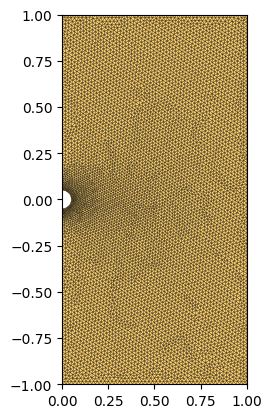

In [4]:
lx = 1.0
ly = 2.0
r = 0.05
mesh, physical_groups = generate_plate(lx, ly, r)
n_dofs_per_node = 2
n_dofs = mesh.coords.shape[0] * n_dofs_per_node

plot_mesh(mesh)

## Problem setup

We now define the `Operator` object that makes the mesh and the associated element type. In this example, we use 3-node triangular element `Tri3`.

In [5]:
from tatva.element import Tri3

op = Operator(mesh, Tri3())

## Defining energy functional

We now define the functions to compute the total strain energy which is mathematically is given as 

$$
\int_{\Omega} \psi_\varepsilon\!\left(\boldsymbol{\varepsilon}(\boldsymbol{u})\right)\,\mathrm{d}\Omega
$$

where 

$$
\psi = \dfrac{1}{2}\sigma:\varepsilon
$$

and  stress and strain is taken for a linear elastic material as

$$
\sigma = 2\mu\varepsilon + \mathrm{tr}(\varepsilon)\mathbb{I}, \quad \varepsilon=\dfrac{1}{2}(\nabla \boldsymbol{u} + \nabla\boldsymbol{u}^\mathrm{T})
$$

!!! note

    To make the looping over each quadrature point computationally efficient, we make use of decorator `@autovmap` from `jax_autovmap` which is basically `jax.vmap` but create the vectorized mapping based on the dimension of the quantity.

    The `autovmap` function works as a python decorator that wraps a function and vectorizes it. The `autovmap` function takes input as the dimension of the variables passed to the function. The different dimensions of an input variable are defined as follows:

        - `0`: scalar (for example, material properties)
        - `1`: vector (for example, a displacement field or any vector with one index)
        - `2`: tensor (for example, a strain tensor, stress tensor or any matrix with two indices)


    In this example, we want to compute stress from strain given as

    $$
    \sigma = 2\mu \epsilon + \lambda \text{tr}(\epsilon) \mathbb{I}
    $$

    where $\sigma$ is the stress tensor, $\epsilon$ is the strain tensor, $\mu$ is the shear modulus, $\lambda$ is the Lame parameter, and $\mathbb{I}$ is the identity tensor. The term $\text{tr}(\epsilon)$ is the trace of the strain tensor. Then we can define our function as

    ```python
    @autovmap(eps=2, mu=0, lmbda=0)
    def compute_stress(eps, mu, lmbda):
        return 2 * mu * eps + lmbda * jnp.trace(eps) * jnp.eye(2)
    ```


In [6]:
class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  
    lmbda: float

    @classmethod
    def from_youngs_poisson_2d(
        cls, E: float, nu: float, plane_stress: bool = False
    ) -> "Material":
        mu = E / 2 / (1 + nu)
        if plane_stress:
            lmbda = 2 * nu * mu / (1 - nu)
        else:
            lmbda = E * nu / (1 - 2 * nu) / (1 + nu)
        return cls(mu=mu, lmbda=lmbda)


mat = Material.from_youngs_poisson_2d(1, 0.3)


@autovmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


@autovmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    return 2 * mu * eps + lmbda * jnp.trace(eps) * jnp.eye(2)


@autovmap(grad_u=2, mu=0, lmbda=0)
def strain_energy_density(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sigma, eps)

@jax.jit
def total_energy_full(u_flat: Array) -> Array:
    """Compute the total energy of the system."""
    u = u_flat.reshape(-1, 2)
    u_grad = op.grad(u)
    e_density = strain_energy_density(u_grad, mat.mu, mat.lmbda)
    return op.integrate(e_density)



## Enforcing boundary condition via static condensation

The boundary conditions are enforced via **static condensation**.  Instead of modifying an assembled linear system, _for example_, via row/column operations or direct elimination of constrained DoFs, we define a reduced functional that depends only on the free degrees of freedom. The reduced displacement vector is lifted to the full field by inserting the prescribed values at constrained locations before evaluating the total energy.


We first locate the DoFs associated to the left and right boundaries and store them as `fixed_dofs` and `free_dofs`. 

In [7]:
boundary_left = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
boundary_right = jnp.where(jnp.isclose(mesh.coords[:, 0], lx))[0]
point_at_y_0 = jnp.where(
    jnp.isclose(mesh.coords[:, 0], lx) & jnp.isclose(mesh.coords[:, 1], 0.0)
)[0][0]
assert point_at_y_0

fixed_dofs = jnp.concatenate(
    [boundary_left * n_dofs_per_node, jnp.array([point_at_y_0 * n_dofs_per_node + 1])]
)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

In [8]:
@jax.jit
def total_energy(u_free: Array) -> Array:
    """Compute the total energy of the system."""
    u_full = jnp.zeros(n_dofs).at[free_dofs].set(u_free)
    return total_energy_full(u_full)


residual_full = jax.jacrev(total_energy_full)
residual = jax.jacrev(total_energy)

## Defining the loading traction on right edge

We define a new `Operator` consisting of line elements along the right edge and then use this `op_line` to integrate the traction along the nodes.

In [9]:
from tatva.element.base import Line2

sig_loading = 1e-2

op_line = Operator(Mesh(mesh.coords, elements=physical_groups["right_edge"]), Line2())
nodal_area = jax.jacrev(op_line.integrate)(jnp.ones(mesh.coords.shape[0]))
f_ext_0 = jnp.zeros(n_dofs)

idx_right = n_dofs_per_node * boundary_right

f_ext_0 = f_ext_0.at[idx_right].add(sig_loading * nodal_area[boundary_right])
f_ext = f_ext_0.at[free_dofs].get()

Now let us define the function that we want to set to `0` i.e.
$$
\boldsymbol{f} = \boldsymbol{f}_\text{ext} - \boldsymbol{f}_\text{int}
$$

and using this function, we can define the Jacobian-vector product

$$
\Delta f = \frac{\partial f}{\partial u}\Delta u
$$

In [10]:
@jax.jit
def fn(u_free: Array) -> Array:
    res = residual(u_free)
    return f_ext - res

@jax.jit
def compute_tangent(du, u_prev):
    tangent = jax.jvp(fn, (u_prev,), (du,))[1]
    return tangent

In [11]:
# [collapse: code] Newton-Krylov solver

import time
from functools import partial


@partial(jax.jit, static_argnames=["gradient","compute_tangent"])
def newton_krylov_solver(
    u,
    gradient,
    compute_tangent,
):
    residual = gradient(u)
    norm_res = jnp.linalg.norm(residual)

    init_val = (u, 0, norm_res)

    def cond_fun(state):
        u, iiter, norm_res = state
        return jnp.logical_and(norm_res > 1e-8, iiter < 10)

    def body_fun(state):
        u, iiter, norm_res = state
        residual = gradient(u)

        start_time = time.time()
        A = jax.jit(partial(compute_tangent, u_prev=u))
        end_time = time.time()
        jax.debug.print("  Assembling tangent matrix time: {time:.2f} s", time=end_time - start_time)

        start_time = time.time()
        du, _ = jax.scipy.sparse.linalg.cg(A=A, b=-residual)
        end_time = time.time()
        jax.debug.print("  CG solve time: {time:.2f} s", time=end_time - start_time)

        u = u + du

        start_time = time.time()
        residual = gradient(u)
        end_time = time.time()
        jax.debug.print("  Residual evaluation time: {time:.2f} s", time=end_time - start_time)
        norm_res = jnp.linalg.norm(residual)

        return (u, iiter + 1, norm_res)

    final_u, final_iiter, final_norm = jax.lax.while_loop(cond_fun, body_fun, init_val)
    jax.debug.print("  Residual: {res:.2e}", res=final_norm)

    return final_u, final_norm

We now solve the system for the applied traction

In [12]:
u_sol, norm_res = newton_krylov_solver(
    u=jnp.zeros_like(f_ext),
    gradient=fn,
    compute_tangent=compute_tangent,
)

  Assembling tangent matrix time: 0.00 s
  Residual evaluation time: 0.00 s
  CG solve time: 0.05 s
  Residual evaluation time: 0.00 s
  Assembling tangent matrix time: 0.00 s
  CG solve time: 0.05 s
  Residual: 1.91e-13


## Visualization and analyzing the results


In [13]:
def stress_cartesian_to_polar(
    sig: np.ndarray | Array, x: np.ndarray | Array
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Convert 2D Cartesian stress to polar components at points x.

    sig: (..., 2, 2) stress tensor at each point.
    x:   (..., 2) coordinates (origin at 0,0).
    returns: (sig_rr, sig_tt, sig_rt) with shape (...,)
    """
    x = np.asarray(x)
    sig = np.asarray(sig)
    theta = np.arctan2(x[..., 1], x[..., 0])
    c = np.cos(theta)
    s = np.sin(theta)
    rot = np.stack([np.stack([c, s], axis=-1), np.stack([-s, c], axis=-1)], axis=-2)
    sig_rt = np.einsum("...ik,...kl,...jl->...ij", rot, sig, rot)
    return sig_rt[..., 0, 0], sig_rt[..., 1, 1], sig_rt[..., 0, 1]

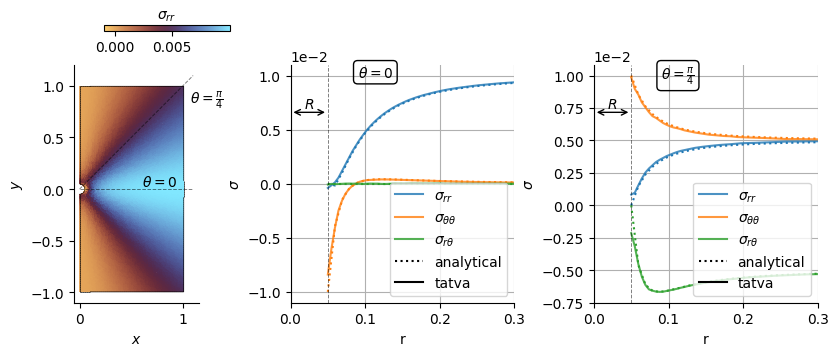

In [23]:
# [collapse: code] Plot stress components along lines at different angles from the hole center

from typing import Literal

import pyvista as pv
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from matplotlib.tri import Triangulation

EPS = 1e-8



u = jnp.zeros(n_dofs).at[free_dofs].set(u_sol)
u = u.reshape(-1, 2)

x_final = mesh.coords + u
tri = Triangulation(x_final[:, 0], x_final[:, 1], mesh.elements)

sig = compute_stress(compute_strain(op.grad(u)), mat.mu, mat.lmbda).squeeze()
sig_rr, sig_tt, sig_rt = stress_cartesian_to_polar(sig, op.eval(x_final).squeeze())

def plot_field(ax: Axes):
    cb = ax.tripcolor(tri, sig_rr, alpha=0.95, rasterized=True, cmap="managua")
    ax.set_aspect("equal")

    edge_elems = jnp.concatenate(
        (
            physical_groups["hole_boundary"],
            physical_groups["left_edge"],
            physical_groups["right_edge"],
            physical_groups["bottom_edge"],
            physical_groups["top_edge"],
        )
    )
    segments = mesh.coords[edge_elems][:, :, :2]
    coll_boundary = LineCollection(
        segments + u[edge_elems][:, :, :2], colors="k", linewidths=0.5
    )
    ax.add_collection(coll_boundary)

    ax.set(
        xlabel="$x$",
        ylabel="$y$",
    )
    return cb



def get_pv_grid(mesh: Mesh) -> pv.UnstructuredGrid:
    """Convert Tatva mesh to PyVista UnstructuredGrid."""
    if mesh.coords.shape[1] == 2:
        pv_points = np.hstack((mesh.coords, np.zeros(shape=(mesh.coords.shape[0], 1))))
    else:
        pv_points = np.array(mesh.coords)
    cells = np.hstack(
        [
            np.full((mesh.elements.shape[0], 1), 3, dtype=np.int64),
            np.array(mesh.elements, dtype=np.int64),
        ]
    )
    grid = pv.UnstructuredGrid(
        cells, np.full(mesh.elements.shape[0], pv.CellType.TRIANGLE), pv_points
    )
    return grid


def kirsch_sig(
    component: Literal["rr", "tt", "rt"],
    load_sig: float,
    r: float,
    theta: float,
    a: float,
) -> Array:
    if component == "rr":
        return (
            0.5
            * load_sig
            * (
                (1 - a**2 / r**2)
                + (1 + 3 * np.power(a, 4) / np.power(r, 4) - 4 * a**2 / r**2)
                * np.cos(2 * theta)
            )
        )
    elif component == "tt":
        return (
            0.5
            * load_sig
            * (
                (1 + a**2 / r**2)
                - (1 + 3 * np.power(a, 4) / np.power(r, 4)) * np.cos(2 * theta)
            )
        )
    elif component == "rt":
        return (
            -0.5
            * load_sig
            * (
                (1 - 3 * np.power(a, 4) / np.power(r, 4) + 2 * a**2 / r**2)
                * np.sin(2 * theta)
            )
        )
    else:
        raise ValueError(f"Unknown component: {component}")


grid = get_pv_grid(mesh)
grid["sig_rr"] = sig_rr
grid["sig_tt"] = sig_tt
grid["sig_rt"] = sig_rt
grid: pv.UnstructuredGrid = grid.cell_data_to_point_data()


def get_sig_data_along_line(
    r: float, lx: float, theta: float
) -> tuple[Array, dict[str, Array]]:
    sample = grid.sample_over_line(
        (r * np.cos(theta), r * np.sin(theta), 0.0),
        (lx * np.cos(theta), lx * np.sin(theta), 0.0),
        resolution=200,
    )
    sig_data = {}
    dist = np.hypot(sample.points[:, 0], sample.points[:, 1])
    idx_sort = np.argsort(dist)
    ri_data, sig_data["rr"], sig_data["tt"], sig_data["rt"] = (
        dist[idx_sort],
        sample["sig_rr"][idx_sort],
        sample["sig_tt"][idx_sort],
        sample["sig_rt"][idx_sort],
    )
    return ri_data, sig_data


fig = plt.figure(figsize=(8.4, 3.4))
gs = fig.add_gridspec(
    1, 3, width_ratios=[0.8, 1.2, 1.2], wspace=0.4, left=0.05, right=0.95, bottom=0.15, top=0.85
)
axes: list[Axes] = gs.subplots()

ri = np.linspace(r, 1, 100)


def plot_stress_component(ax: Axes, theta: float) -> None:
    color_iter = iter(plt.rcParams["axes.prop_cycle"])
    for comp in ["rr", "tt", "rt"]:
        ri_data, sig_data = get_sig_data_along_line(r, lx, theta=theta)
        c = next(color_iter)["color"]
        label = comp
        if comp == "tt":
            label = "\\theta\\theta"
        elif comp == "rt":
            label = "r\\theta"
        ax.plot(
            ri_data,
            sig_data[comp],
            c=c,
            label=rf"$\sigma_{{{label}}}$",
            alpha=0.8,
        )
        ax.plot(
            ri,
            kirsch_sig(comp, sig_loading, ri, theta, r),
            c=c,
            ls=":",
            lw=1.5,
            # marker="o",
            # markersize=3,
            # mec="w",
        )

    ax.set(
        xlabel="r",
        ylabel=r"$\sigma$",
        xlim=(0, 1),
    )
    ax.grid()
    ax.axvline(r, color="k", linestyle="--", linewidth=0.7, alpha=0.5)
    legend = ax.legend()
    legend_elements = [
        Line2D([0], [0], color="k", linestyle=":", label="analytical"),
        Line2D([0], [0], color="k", linestyle="-", label="tatva"),
    ]
    legend = ax.legend(
        handles=[*legend.legend_handles, *legend_elements],
        loc="lower right",
        # bbox_to_anchor=(1, 0.2),
    )


for ax, theta, theta_str in zip(axes[1:], (0.0, np.pi / 4), (r"0", r"\frac{\pi}{4}")):
    ax.annotate(
        rf"$\theta={theta_str}$",
        xy=(0.3, 1.00),
        xycoords="axes fraction",
        va="top",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="none"),
    )
    plot_stress_component(ax, theta=theta)
    ax.set_xlim((0, 0.3))

m = plot_field(axes[0])
cax = fig.add_axes((0.1, 0.95, 0.15, 0.018))
cb = plt.colorbar(
    m,
    cax=cax,
    label=r"$\sigma_{rr}$",
    shrink=0.7,
    pad=0.12,
    orientation="horizontal",
)
cb.ax.xaxis.set_label_position("top")


for ax in axes[:]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

for _ax in axes[1:]:
    # set y-axis to scientific notation
    _ax.yaxis.get_major_formatter().set_scientific(True)
    _ax.yaxis.get_major_formatter().set_powerlimits((-2, 2))

    # Draw a horizontal arrow from x=0 to x=r at y=0.95 of the y-axis
    _ax.annotate(
        "",
        xy=(r, 0.8),
        xytext=(0, 0.8),
        xycoords=("data", "axes fraction"),
        arrowprops=dict(arrowstyle="<->", color="k"),
        annotation_clip=False,
    )
    _ax.annotate(
        r"$R$",
        xy=(r / 2, 0.8),
        xytext=(0, 1),
        textcoords="offset points",
        xycoords=("data", "axes fraction"),
        ha="center",
        va="bottom",
    )

ax = axes[0]
# Draw a dashed line from the center to the outer boundary at theta=0
ax.plot([0, 1.1], [0, 0], linestyle="--", color="k", lw=0.7, alpha=0.5)
ax.annotate(
    r"$\theta=0$", xy=(0.6, 0.0), xytext=(0, 2), textcoords="offset points", color="k"
)
ax.plot([0, 1.1], [0, 1.1], linestyle="--", color="k", lw=0.7, alpha=0.5)
ax.annotate(
    r"$\theta=\frac{\pi}{4}$",
    xy=(1, 1),
    xytext=(5, -2),
    textcoords="offset points",
    color="k",
    va="top",
)


def subplot_label(ax, label, w_inches=-0.3, h_inches=0.08):
    """Add a label to a subplot.

    Args:
        ax: axis to add the label to
        label: label to add
        w_inches: width offset
        h_inches: height offset
    """
    w, h = ax.get_figure().get_size_inches()
    ax.text(
        w_inches / ax.get_position().width / w,
        1 + h_inches / ax.get_position().height / h,
        rf"\textbf{{{label})}}",
        transform=ax.transAxes,
        va="bottom",
        # fontfamily="serif",
        fontweight="bold",
        # fontsize="large",
    )

